In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [2]:
base_dir = "../data/processed"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20

print("Train:", len(train_dir))
print("Val:", len(val_dir))
print("Test:", len(test_dir))

Train: 23
Val: 21
Test: 22


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 216 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


In [4]:
labels = train_generator.classes

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
class_weights


{0: 0.782608695652174, 1: 1.1612903225806452, 2: 1.1612903225806452}

In [7]:
from tensorflow.keras.models import Sequential

resnet_base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in resnet_base.layers:
    layer.trainable = False

resnet_model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation="softmax")
])

resnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24113027 (91.98 MB)
Trainable params: 525315 (2.00 MB)
Non-trainable params: 23587712 (89.98 MB)
___________

In [9]:
from tensorflow.keras.optimizers import Adam

resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
import os

base_dir = os.path.dirname(os.getcwd())   
model_dir = os.path.join(base_dir, "models")

os.makedirs(model_dir, exist_ok=True)
print("Models will be saved to:", model_dir)


Models will be saved to: C:\Users\Mounika\models


In [20]:
resnet_callbacks = [
    ModelCheckpoint(
        os.path.join(model_dir, "best_resnet50.h5"),
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        verbose=1
    )
]


In [21]:
resnet_history = resnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=resnet_callbacks
)


Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 0.9221 - accuracy: 0.5741
Epoch 1: val_loss improved from inf to 0.82832, saving model to C:\Users\Mounika\models\best_resnet50.h5
14/14 [==============================] - 18s 1s/step - loss: 0.9221 - accuracy: 0.5741 - val_loss: 0.8283 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 0.8769 - accuracy: 0.6713
Epoch 2: val_loss improved from 0.82832 to 0.81485, saving model to C:\Users\Mounika\models\best_resnet50.h5
14/14 [==============================] - 17s 1s/step - loss: 0.8769 - accuracy: 0.6713 - val_loss: 0.8148 - val_accuracy: 0.7708 - lr: 1.0000e-04
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 0.8866 - accuracy: 0.6667
Epoch 3: val_loss did not improve from 0.81485
14/14 [==============================] - 16s 1s/step - loss: 0.8866 - accuracy: 0.6667 - val_loss: 0.8180 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 4/20
14/14 [=

In [22]:
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_generator)

print("ResNet Test Accuracy:", resnet_test_acc)
print("ResNet Test Loss:", resnet_test_loss)


3/3 [==============================] - 3s 958ms/step - loss: 0.7669 - accuracy: 0.7500
ResNet Test Accuracy: 0.75
ResNet Test Loss: 0.7668747901916504


3/3 [==============================] - 3s 878ms/step


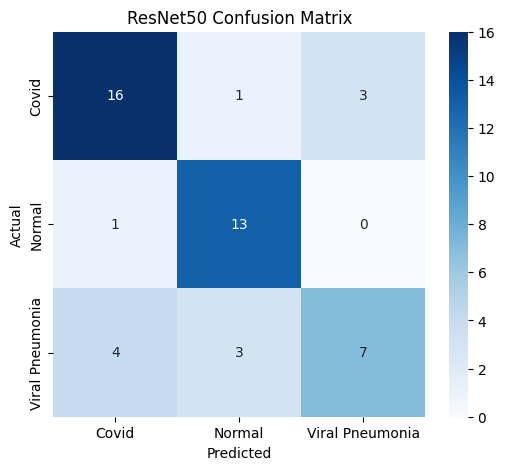

                 precision    recall  f1-score   support

          Covid       0.76      0.80      0.78        20
         Normal       0.76      0.93      0.84        14
Viral Pneumonia       0.70      0.50      0.58        14

       accuracy                           0.75        48
      macro avg       0.74      0.74      0.73        48
   weighted avg       0.74      0.75      0.74        48



In [23]:
pred_probs = resnet_model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_generator.classes

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm_resnet = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_resnet,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=test_generator.class_indices.keys(),
    yticklabels=test_generator.class_indices.keys()
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ResNet50 Confusion Matrix")
plt.show()

print(classification_report(
    true_labels,
    pred_labels,
    target_names=test_generator.class_indices.keys()
))


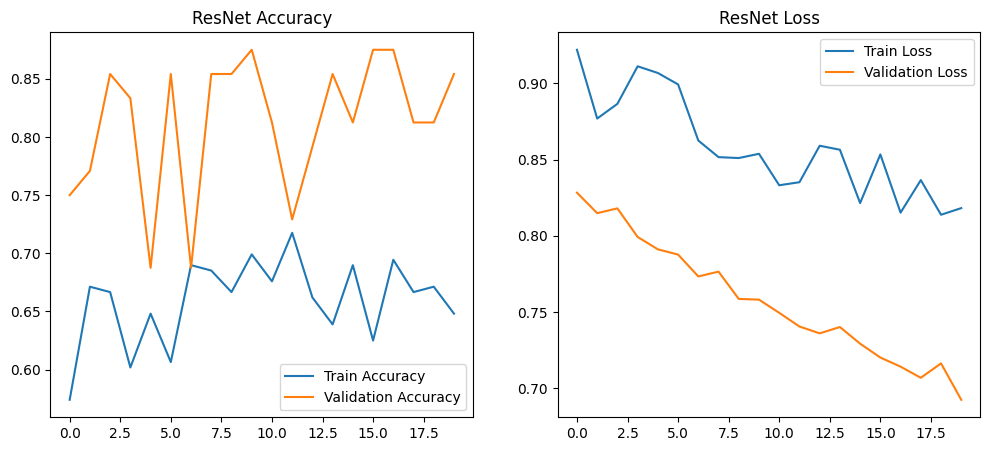

In [24]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(resnet_history.history["accuracy"], label="Train Accuracy")
plt.plot(resnet_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("ResNet Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(resnet_history.history["loss"], label="Train Loss")
plt.plot(resnet_history.history["val_loss"], label="Validation Loss")
plt.title("ResNet Loss")
plt.legend()

plt.show()


In [25]:
resnet_model.save(os.path.join(model_dir, "final_resnet50.h5"))
print("ResNet50 model saved successfully!")


ResNet50 model saved successfully!
